In [1]:
import cv2 as cv
import subprocess
import re
from pyproj import Transformer
from shapely import geometry, affinity
import rioxarray as rxr
import rasterio
import rasterio.transform
from rasterio.control import GroundControlPoint
from rasterio.transform import from_gcps
import numpy as np
from PIL import Image
from osgeo import gdal, osr; gdal.UseExceptions()
import os
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import affine
import torch
import networkx
import pickle
import pandas as pd
import shutil
import random
import importlib.util
from rioxarray.merge import merge_arrays

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

In [2]:
DATA_DIR = "data/20221220_Sudol"
CFG = load_config(f"{DATA_DIR}/config.py").GEOREFERENCING

In [3]:
TMP_DIR = f"{DATA_DIR}/tmp"
os.makedirs(TMP_DIR, exist_ok=True)
TIF_UNCAL_DIR = f"{DATA_DIR}/tif_uncal"
assert os.path.isdir(TIF_UNCAL_DIR), f"{TIF_UNCAL_DIR} does not exist"
GEOTIF_UNCAL_DIR = f"{DATA_DIR}/geotif_uncal"
OVERLAYS_DIR = f"{DATA_DIR}/overlays"
CACHE_DIR = f"{DATA_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [4]:
# seeding
cv.setRNGSeed(0)

class Stitcher(object):
    """Stitches images together. Params default to standard ones.

    Args:

        lowe_ratio (float): Lowe's ratio for discarding false matches
            the lower, the more false matches are discarded, defaults to 0.7
        min_inliers (int): minimum number of matches to attempt
            estimation of affine transform, the higher, the more high-quality
            the match, defaults to 200, this is also used for checking whether
            a higher resolution image should be used, higher res matching
            is attempted when no. of inliers from RANSAC < min_inliers
        ransac_reproj_threshold (float): max reprojection error in RANSAC
            to consider a point as an inlier, the higher, the more tolerant
            RANSAC is, defaults to 3.0
    """

    def __init__(self,
                 lowe_ratio=0.7,
                 min_inliers=10,
                 ransac_reproj_threshold=3.0):
        # create feature detector
        self.fd = cv.SIFT_create()
        # feature matcher
        FLANN_INDEX_KDTREE = 1
        self.mt = cv.FlannBasedMatcher({'algorithm': FLANN_INDEX_KDTREE})
        # Lowe's ratio for discarding false matches
        self.lowe_ratio = lowe_ratio
        # minimum feature matches to attempt transform estimation
        # if RANSAC inliers < min_inliers, higher resolution images are used
        self.min_inliers = min_inliers
        # RANSAC reprojection threshold
        # maximum reprojection error in the RANSAC algorithm
        # to consider a point as an inlier
        self.ransac_reproj_threshold = ransac_reproj_threshold

    def relative_affine(self, img0, img1):
        """Estimates the relative affine transformation.

        Args:
            img0, img1 (numpy.Array)

        Returns:
            affine.Affine or NoneType: affine transform to fit
                img1 onto img0, None if no match is found
        """
       
        
        
        # detect features, compute descriptors
        kp0, des0 = self.fd.detectAndCompute(img0, mask=None)
        kp1, des1 = self.fd.detectAndCompute(img1, mask=None)
        # match descriptors
        matches = self.mt.knnMatch(des0, des1, k=2)  # query, train
        # store all the good matches as per Lowe's ratio test
        good = []
        for m0, m1 in matches:
            if m0.distance < self.lowe_ratio * m1.distance:
                good.append(m0)
        # with all good matches, estimate affine transform w/ RANSAC
        if len(good) < self.min_inliers:
            return None
        pts0 = np.array([kp0[m.queryIdx].pt for m in good])
        pts1 = np.array([kp1[m.trainIdx].pt for m in good])
        transform, inliers = cv.estimateAffinePartial2D(
            pts1, pts0,
            method=cv.RANSAC,
            ransacReprojThreshold=self.ransac_reproj_threshold)
        if inliers.sum() < self.min_inliers:
            return None   
        transform = rasterio.transform.Affine(*transform.flatten())
        # img_overlay = cv.warpAffine(src=img1, M=np.array(transform).reshape(3,3)[:2], dsize=img0.shape[::-1])
        # # overlay with 50% transparency
        # img_overlay = cv.addWeighted(img0, 0.5, img_overlay, 0.5, gamma=0.0)
        # #random number for file name
        # r = random.randint(0, 1000)
        # cv.imwrite(f"{OVERLAYS_DIR}/overlay_{r}.png", img_overlay)
        
        return transform

    def absolute_affine(self, src_img, dst_img, dst_trans):
        """Stitch source image to destination image.

        Args:
            src_img, dst_img (str): file path
            dst_trans (affine.Affine): dst_img image transform

        Returns:
            affine.Affine or NoneType: affine transform to fit
                src_img onto dst_img, None if no match is found
                the relative transform is in terms of the original images
        """
        relative_trans = self.relative_affine(dst_img, src_img)
        # return if transform is found
        if relative_trans is None:
            return None
        # return the absolute transform
        trans = dst_trans * relative_trans
        return trans
    
def img2geotif(in_path, out_path, transform, crs):
    """Convert image to geotiff.
    Args:
        img_path (str): image file path
        transform (affine.Affine or numpy.array): affine transform 3x3 matrix
        out_path (str): output geotiff file path
    """
    if not isinstance(transform, affine.Affine):
        transform = affine.Affine(*transform.flatten()[:6])
    arr = np.array(Image.open(in_path)).squeeze()
    with rasterio.open(f"{TMP_DIR}/raster.tif", 'w', driver='GTiff', height=arr.shape[0], width=arr.shape[1], count=1, dtype=arr.dtype, crs=crs, transform=transform) as dst:
        dst.write(arr, 1)
    gdal.Warp(out_path, f"{TMP_DIR}/raster.tif", format='GTiff', dstSRS=crs, dstNodata=-9999)
    
def estimate_affine_from_params(translation_x, translation_y, scale, rotation):
    """Estimates affine transform from parameters.
    Args:
        translation_x (float): translation in x direction
        translation_y (float): translation in y direction
        scale (float): scale
        rotation (float): rotation in radians
    Returns:
        affine (numpy.array): affine transform 2x3 matrix
    """
    #Non-standard orientation of the coordinate system (cos, sin, x, sin, -cos, y)
    transform = np.array([[scale*np.cos(rotation), scale*np.sin(rotation), translation_x], [scale*np.sin(rotation), -scale*np.cos(rotation), translation_y]])
    return transform

def dms2dec(dms):
    """Converts DMS (degrees, minutes, seconds) to decimal degrees.
    Args:
        dms (list): DMS coordinates
    Returns:
        float: decimal degrees
    """
    d = float(dms[0])
    m = float(dms[1])
    s = float(dms[2])
    return (d+m/60+s/3600)*(-1 if dms[3] in ['W', 'S'] else 1)

def fetch_H20t_exif(img_path):
    """Camera dependent EXIF data fetcher.
    Args:
        img_path (str): image file path
    Returns:
        exif (dict): EXIF data with fields: lat, lon, alt, yaw, dfov_deg, width, height
    """
    lat, lon, yaw, alt = subprocess.run(['exiftool', '-GPSLatitude', '-GPSLongitude', '-GimbalYawDegree', '-RelativeAltitude', img_path], stdout=subprocess.PIPE).stdout.decode("utf-8").splitlines()
    lat = lat.split(":",1)[1].strip()
    lat = [x.strip() for x in re.split('[deg\'"]', lat) if x]
    lat = dms2dec(lat)
    lon = lon.split(":",1)[1].strip()
    lon = [x.strip() for x in re.split('[deg\'"]', lon) if x]
    lon = dms2dec(lon)
    yaw = float(yaw.split(":",1)[1].strip())
    alt = float(alt.split(":",1)[1].strip())
    return {'lat': lat, 'lon': lon, 'alt': alt, 'yaw': yaw}

class ExifGeoreferencer:
    """Georeference images by EXIF data."""
    def __init__(self, width=640, height=512, dfov_d=40., utm_zone="EPSG:32634", exif_fetcher=fetch_H20t_exif):
        """Initialize georeferencer.
        Args:
            width, height (int): image size in pixels
            dfov_d (float): diagonal field of view in degrees
            utm_zone (str): UTM zone
            exif_fetcher (function): function to fetch EXIF data
        """
        self.dfov_d = dfov_d
        self.width = width
        self.height = height
        self.diag_pix = np.sqrt(width**2 + height**2)
        self.hcoef = width/self.diag_pix
        self.vcoef = height/self.diag_pix
        self.utm_zone = utm_zone
        self.exif_fetcher = exif_fetcher

    def estimate_transforms(self, img_path):
        """Get transform parameters from EXIF data.
        Args:
            img_path (str): image file path
        Returns:
            translation_x, translation_y, rotation, scale (float): transform parameters
            footprint (geometry.Polygon): image footprint in UTM coordinates
        """
        exif = self.exif_fetcher(img_path)
        dfov_m = 2*exif["alt"]*np.tan(self.dfov_d/2*np.pi/180)
        vfov_m = self.vcoef*dfov_m
        hfov_m = self.hcoef*dfov_m
        pixel_size = dfov_m/819.5999023914046
        transformer = Transformer.from_crs("epsg:4326", self.utm_zone, always_xy=True)
        x, y = transformer.transform(exif["lon"], exif["lat"])
        #convert degres to radians
        rotation = -exif["yaw"]
        rotation = (rotation)*np.pi/180
        #moving from image center to its corner
        dx =dfov_m/2*np.cos(np.pi - (np.arctan(512./640.) - rotation))
        dy =dfov_m/2*np.sin(np.pi - (np.arctan(512./640.) - rotation))
        translation_x = x+dx
        translation_y = y+dy
        scale = pixel_size
        footprint = geometry.Polygon([(x-hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y-vfov_m/2), (x+hfov_m/2, y+vfov_m/2), (x-hfov_m/2, y+vfov_m/2)])
        footprint = affinity.rotate(footprint,-exif['yaw'], origin="centroid")
        return translation_x, translation_y, scale, rotation, footprint

    def estimate_affine_from_img(self, img_path):
        translation_x, translation_y, scale, rotation = self.estimate_transforms(img_path)
        return estimate_affine_from_params(translation_x, translation_y, scale, rotation)

Get initial georeferences for all images basing on EXIF data

In [5]:
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/all_images.pkl"):
    all_images = pd.read_pickle(f"{CACHE_DIR}/all_images.pkl")
else:
    exifGeoreferencer = ExifGeoreferencer(width=640, height=512, dfov_d=CFG.DFOV, utm_zone="EPSG:32634", exif_fetcher=fetch_H20t_exif)
    all_names = []
    all_rotations = []
    all_scales = []
    all_xs = []
    all_ys = []
    all_footprints = []
    all_abs_transforms = []
    for file_path in tqdm(glob(f"{TIF_UNCAL_DIR}/*.tif")):
        file_name = os.path.basename(file_path)
        x, y, scale, rotation, footprint = exifGeoreferencer.estimate_transforms(file_path)
        all_abs_transforms.append(estimate_affine_from_params(x, y, scale, rotation))
        all_names.append(file_name)
        all_rotations.append(rotation)
        all_scales.append(scale)
        all_xs.append(x)
        all_ys.append(y)
        all_footprints.append(footprint)
    all_rotations = np.array(all_rotations, dtype=np.float32)
    all_scales = np.array(all_scales, dtype=np.float32)
    all_xs = np.array(all_xs, dtype=np.float32)
    all_ys = np.array(all_ys, dtype=np.float32)
    all_images = pd.DataFrame({"name": all_names, "rotation": all_rotations, "scale": all_scales, "x": all_xs, "y": all_ys, "footprint": all_footprints, "abs_transform": all_abs_transforms})
    all_images.to_pickle(f"{CACHE_DIR}/all_images.pkl")

100%|██████████| 469/469 [01:17<00:00,  6.07it/s]


Get pairs of images and obtain for them relative affines.

In [6]:
corners_indices = np.array([[0,0,1], [0,512,1], [640,512,1], [640,0,1]], dtype=np.float32)
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/all_pairs.pkl"):
    all_pairs = pd.read_pickle(f"{CACHE_DIR}/all_pairs.pkl")
else:
    stitcher = Stitcher(min_inliers=CFG.MIN_INLIERS)
    all_pairs_i = []
    all_pairs_j = []
    all_relative_transformations = []
    #buffer footprints to detect intersections of images even if they are not perfectly aligned
    all_footprints_buffered = [footprint.buffer(CFG.DILATION) for footprint in all_images["footprint"]]
    #iterate over pairs of images without repetition
    for i in tqdm(range(len(all_images))):
        img_path_i = f"{TIF_UNCAL_DIR}/{all_images['name'][i]}"
        img_0 = np.array(Image.open(img_path_i)).squeeze()
        img_0 = cv.normalize(img_0, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        for j in range(i+1,len(all_images)):
            if not all_footprints_buffered[i].intersects(all_footprints_buffered[j]):
                continue
            img_path_j = f"{TIF_UNCAL_DIR}/{all_images['name'][j]}"
            img_1 = np.array(Image.open(img_path_j)).squeeze()
            img_1 = cv.normalize(img_1, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
            relative_transformation = stitcher.relative_affine(img_0, img_1)
            if relative_transformation is None:
                continue
            relative_transformation = np.array(relative_transformation, dtype=np.float32).reshape(3,3)
            all_relative_transformations.append(relative_transformation)
            all_pairs_i.append(i)
            all_pairs_j.append(j)
    all_relative_transformations = np.stack(all_relative_transformations)
    all_corners_coords = np.matmul(all_relative_transformations, np.transpose(corners_indices), dtype=np.float32)
    all_pairs = pd.DataFrame({"i": all_pairs_i, "j": all_pairs_j, "rel_trans": list(all_relative_transformations), "corners": list(all_corners_coords)})
    all_pairs.to_pickle(f"{CACHE_DIR}/all_pairs.pkl")

100%|██████████| 469/469 [52:57<00:00,  6.78s/it] 


Remove outlier pairs where the relative transformation scale is out of 0.98 and 1.02 range.

In [15]:
#get scales from all_pairs["rel_trans"]
rel_scales = np.stack(all_pairs["rel_trans"].apply(lambda x: np.linalg.norm(x[:,:2], axis=0)).values)
#find deviations out of 0.2
outliers = np.abs(rel_scales - 1) > 0.2
outliers = np.any(outliers, axis=1)
#remove outliers
all_pairs = all_pairs[~outliers]

Interpet pairs as graph and get unconnected components. Only images from component with the largest amount of nodes will processed.

In [16]:
graph = networkx.Graph(all_pairs[["i", "j"]].values.tolist())
#find connected components
components = list(networkx.connected_components(graph))
#get lagest component
component = list(max(components, key=len))

Plot graph

(421438.3857559647, 421593.3327958203, 5550239.58249185, 5550408.907803078)

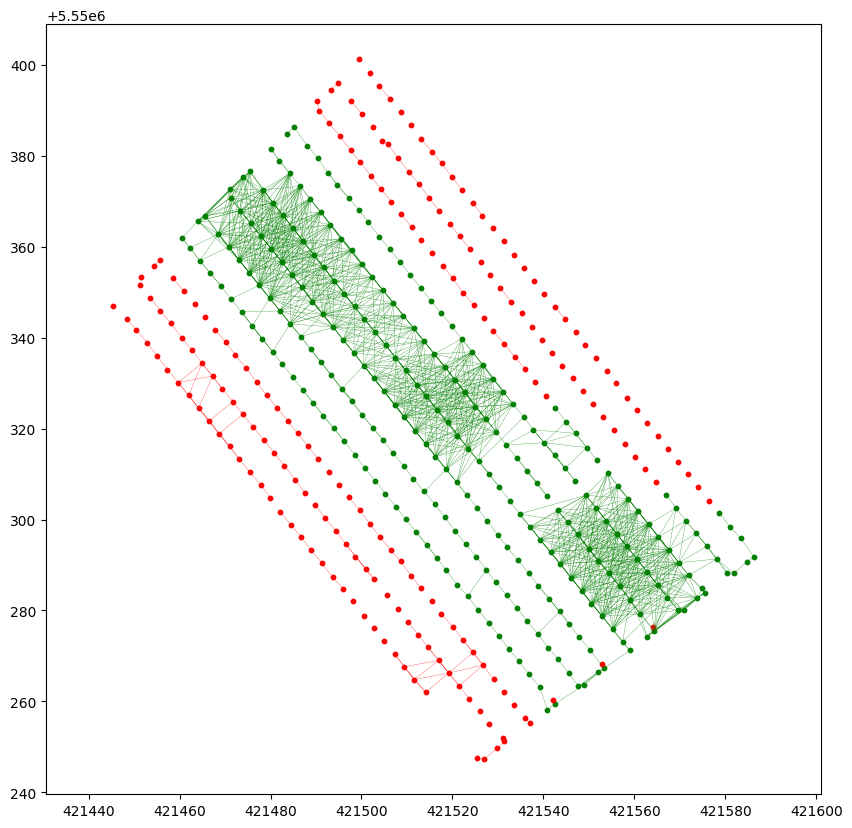

In [17]:
#plot centroids
fig, ax = plt.subplots(figsize=(10,10))
for i, footprint in enumerate(all_images["footprint"].values.tolist()):
    c = "green" if i in component else "red"
    ax.scatter(footprint.centroid.x, footprint.centroid.y, s=10, c=c)
#plot lines between pairs
for i, j in all_pairs[["i", "j"]].values.tolist():
    c = "green" if i in component and j in component else "red"
    ax.plot([all_images["footprint"][i].centroid.x, all_images["footprint"][j].centroid.x], [all_images["footprint"][i].centroid.y, all_images["footprint"][j].centroid.y], color=c, linewidth=0.2)
plt.axis('equal')

Remove elements that are not in the largest component. Indexes in `pairs_i` and `pairs_j` need to be updated.

In [18]:
images = all_images[all_images.index.isin(component)]
images = images.reset_index()
pairs = all_pairs[all_pairs["i"].isin(component) & all_pairs["j"].isin(component)]
#update i and j indexes in pairs
pairs["i"] = pairs["i"].apply(lambda x: images[images["index"]==x].index[0])
pairs["j"] = pairs["j"].apply(lambda x: images[images["index"]==x].index[0])

/tmp/ipykernel_9195/4076042725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs["i"] = pairs["i"].apply(lambda x: images[images["index"]==x].index[0])
/tmp/ipykernel_9195/4076042725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs["j"] = pairs["j"].apply(lambda x: images[images["index"]==x].index[0])


Visualise relative tranformations to examine if they are correct.

In [19]:
recreate_dir(OVERLAYS_DIR)
for i, j, relative_transformation, j_corners_coords in pairs[(pairs["i"]==80) & (pairs["j"]==134)].itertuples(index=False):
    #clear overlays_dir
    img0 = np.array(Image.open(f"{TIF_UNCAL_DIR}/{images['name'][i]}"))
    img1 = np.array(Image.open(f"{TIF_UNCAL_DIR}/{images['name'][j]}"))
    img0 = cv.normalize(img0, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    #pad img0 right and bottom with 500px
    img0 = np.pad(img0, ((0,500),(0,500)), mode="constant", constant_values=0)
    img1 = cv.normalize(img1, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    img_overlay = cv.warpAffine(src=img1, M=np.array(relative_transformation)[:2], dsize=img0.shape[::-1])
    # overlay with 50% transparency
    img_overlay = cv.addWeighted(img0, 0.5, img_overlay, 0.5, gamma=0.0)
    #plot points at corners coordinates
    for corner_coord in np.transpose(j_corners_coords):
        pass
        #img_overlay = cv.circle(img_overlay, tuple(corner_coord[:2].round().astype(np.int32)), 10, (255,255,255), -1)
        #write coordinates near each point
        #img_overlay = cv.putText(img_overlay, f"{corner_coord[0]:.2f}, {corner_coord[1]:.2f}", tuple(corner_coord[:2].round().astype(np.int32)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    #plot points at img0 corners
    # for corner_coord in np.transpose(corners_indices):
    #     img_overlay = cv.circle(img_overlay, tuple(corner_coord[:2].round().astype(np.int32)), 5, (255,255,255), -1)
    #     #write coordinates near each point
    #     img_overlay = cv.putText(img_overlay, f"{corner_coord[0]:.2f}, {corner_coord[1]:.2f}", tuple(corner_coord[:2].round().astype(np.int32)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        
    cv.imwrite(f"{OVERLAYS_DIR}/overlay_{i}_{j}.png", img_overlay)

Globally optimize

In [20]:
pairs["i"].values

array([  0,   0,   1, ..., 260, 261, 262])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# convert to tensors
thetas = torch.tensor(images["rotation"].values, dtype=torch.float64, requires_grad=True, device=device)
scales_x = torch.tensor(images["scale"].values, dtype=torch.float64, requires_grad=True, device=device)
scales_y = torch.tensor(images["scale"].values, dtype=torch.float64, requires_grad=True, device=device)
shears_x = torch.tensor(np.zeros(len(images)), dtype=torch.float64, requires_grad=True, device=device)
shears_y = torch.tensor(np.zeros(len(images)), dtype=torch.float64, requires_grad=True, device=device)
xs = torch.tensor(images["x"].values, dtype=torch.float64, requires_grad=True, device=device)
ys = torch.tensor(images["y"].values, dtype=torch.float64, requires_grad=True, device=device)
corners_indices = torch.tensor(corners_indices, dtype=torch.float64, device=device)
corners_coords = torch.tensor(np.stack(pairs["corners"]), dtype=torch.float64, device=device)
pairs_i = torch.tensor(pairs["i"].values, dtype=torch.int64, device=device)
pairs_j = torch.tensor(pairs["j"].values, dtype=torch.int64, device=device)
centroid_indices = torch.tensor([CFG.WIDTH/2., CFG.HEIGHT/2., 1.], dtype=torch.float64, device=device)
centroid_coords = torch.tensor([[geometry.centroid.x, geometry.centroid.y, 1.] for geometry in images["footprint"]], dtype=torch.float64, device=device)
# initialize optimizer and scheduler
optimizer = torch.optim.Adam([thetas, scales_x, scales_y, shears_x, shears_y, xs, ys], lr=CFG.INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=CFG.LR_PLATEAU_FACTOR, patience=CFG.LR_PLATEAU_PATIENCE, cooldown=CFG.LR_PLATEAU_COOLDOWN ,verbose=True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=CFG.LR_MILESTONES, gamma=0.1)

# iterate n_iter times
best_loss = np.inf
es_counter = 0
losses = []
for k in (pbar := tqdm(range(CFG.N_ITER))):
    optimizer.zero_grad()
    # compute absolute affine transformation
    affines_1 = torch.stack([
        torch.cos(thetas),
        torch.sin(thetas),
        xs,
        torch.sin(thetas),
        -torch.cos(thetas),
        ys,
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.ones(len(component), dtype=torch.float64)]).T.view(-1, 3, 3)
    affines_2 = torch.stack([
        scales_x,
        shears_x,
        torch.zeros(len(component), dtype=torch.float64),
        shears_y,
        scales_y,
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.zeros(len(component), dtype=torch.float64),
        torch.ones(len(component), dtype=torch.float64)]).T.view(-1, 3, 3)
    affines = torch.matmul(affines_1, affines_2)
    # extract i, j affines to estimate relative affines
    affines_i = affines[pairs_i]
    affines_j = affines[pairs_j]
    # get estimated relative affines
    relative_transformations_estimated = torch.matmul(torch.inverse(affines_i), affines_j)
    corners_coords_estimated = torch.matmul(relative_transformations_estimated, np.transpose(corners_indices))
    centroid_coords_estimated = torch.matmul(affines, np.transpose(centroid_indices))
    rel_losses = ((corners_coords_estimated - corners_coords) ** 2).sum(axis=1)**0.5 # relative position losses
    abs_losses = ((centroid_coords_estimated - centroid_coords) ** 2).sum(axis=1)**0.5 # absolute position losses
    rel_loss = rel_losses.mean()
    abs_loss = CFG.ABS_LOSS_FACTOR*abs_losses.mean()
    pbar.set_description(f"rel_loss: {rel_loss.item()}, abs_loss: {abs_loss.item()}")
    loss = rel_loss + abs_loss
    losses.append(loss.item())
    #earli stopping
    if best_loss-loss.item() > CFG.ES_MIN_DELTA:
        best_loss = loss.item()
        best_affines = affines.detach().cpu().numpy()
        es_counter = 0
    else:
        es_counter += 1
        if es_counter > CFG.ES_PATIENCE:
            print("Early stopping")
            break
    
    # back propagate
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

/tmp/ipykernel_9195/2628426030.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corners_indices = torch.tensor(corners_indices, dtype=torch.float64, device=device)
rel_loss: 4.30560147969604, abs_loss: 4.233555236873853e-07:   2%|▏         | 1696/100000 [00:10<09:46, 167.72it/s]   

Epoch 01671: reducing learning rate of group 0 to 1.0000e-04.


rel_loss: 4.247412794991902, abs_loss: 4.3442669738350406e-07:   6%|▌         | 5522/100000 [00:36<10:09, 154.95it/s] 

Epoch 05499: reducing learning rate of group 0 to 1.0000e-05.


rel_loss: 4.245231939290408, abs_loss: 4.357139073348725e-07:   6%|▌         | 6029/100000 [00:39<10:28, 149.58it/s]  

Epoch 06000: reducing learning rate of group 0 to 1.0000e-06.


rel_loss: 4.2450213498403615, abs_loss: 4.359627527935665e-07:   7%|▋         | 6524/100000 [00:42<10:51, 143.44it/s] 

Epoch 06501: reducing learning rate of group 0 to 1.0000e-07.


rel_loss: 4.244997232181911, abs_loss: 4.359806152270171e-07:   7%|▋         | 7010/100000 [00:46<11:07, 139.26it/s]  

Epoch 07002: reducing learning rate of group 0 to 1.0000e-08.


rel_loss: nan, abs_loss: nan:  24%|██▍       | 23894/100000 [02:43<08:42, 145.76it/s]                                  


Early stopping


In [22]:
csv_string = "name,0_0,0_1,0_2,1_0,1_1,1_2,2_0,2_1,2_2\n"
recreate_dir(GEOTIF_UNCAL_DIR)
for transform, name in zip(tqdm(best_affines), images["name"].values):
    img2geotif(f"{TIF_UNCAL_DIR}/{name}", f"{GEOTIF_UNCAL_DIR}/{name}", transform, CFG.CRS)
    csv_string = csv_string + f"{name},{transform[0, 0]},{transform[0, 1]},{transform[0, 2]},{transform[1, 0]},{transform[1, 1]},{transform[1, 2]},{transform[2, 0]},{transform[2, 1]},{transform[2, 2]}\n"
#save csv string to file
with open(f"{DATA_DIR}/affines.csv", "w") as f:
    f.write(csv_string)

100%|██████████| 264/264 [00:45<00:00,  5.80it/s]
